In [1]:
from google.colab import drive
drive.mount('/content/drive')

#install necessary library
#!pip install matplotlib-venn
#!apt-get -qq install -y libfluidsynth1
# https://pypi.python.org/pypi/libarchive
#!apt-get -qq install -y libarchive-dev && pip install -U libarchive
#import libarchive
# https://pypi.python.org/pypi/pydot
#!apt-get -qq install -y graphviz && pip install pydot
#import pydot
#!pip install cartopy
#import cartopy

##
from pandas.core.algorithms import mode
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from google.colab.patches import cv2_imshow

!ls drive/MyDrive/data_china
path = Path('drive/MyDrive/data_china/')
print(path)


lableFile = Path('drive/MyDrive/labels - labels.csv') #file excel label all names of class
batch_size_val = 4
step_per_epoch_val = 200
epochs_val=  4
imageDimensions = (32,32,3)
testRatio = 0.2
validationRatio = 0.2

count = 0
images = []
classNo = []
myList = os.listdir(path)  #need to modify this code
noOfClasses = len(myList)
print("Load classes ....")
for x in range (0,len(myList)):
    myPicList = os.listdir(str(path) + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(str(path)+"/"+str(count)+"/"+y)
        curImg = cv2.resize(curImg,(32,32))
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)





Mounted at /content/drive
0  10  12  14  16  18  2   21  23  25  27  4  6  8
1  11  13  15  17  19  20  22  24  26  3   5  7  9
drive/MyDrive/data_china
Load classes ....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27  


drive/MyDrive/labels.csv
Data Shapes
Train(1357, 32, 32, 3) (1357,)
data shape (28, 2) <class 'pandas.core.frame.DataFrame'>
[83, 31, 43, 171, 67, 116, 54, 92, 3, 1, 47, 84, 63, 28, 80, 14, 85, 93, 5, 3, 10, 6, 12, 6, 63, 1, 77, 19]


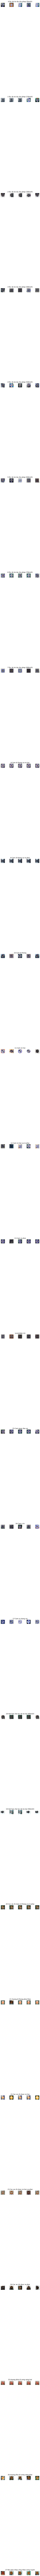

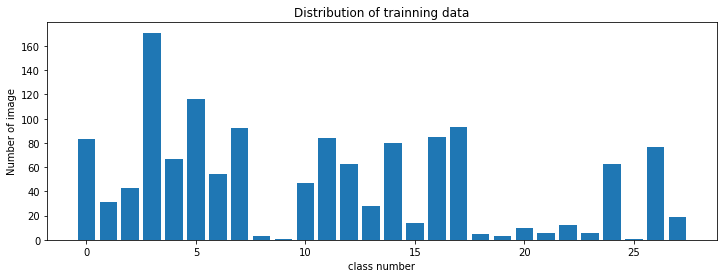

In [2]:


!ls drive/MyDrive/labels.csv

x_train, x_test, y_train, y_test = train_test_split(images,classNo,test_size = testRatio)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = validationRatio)
print("Data Shapes")
print("Train",end="");print(x_train.shape,y_train.shape)

#data = pd.read_csv(lableFile, sep='delimiter', header=None)
data = pd.read_csv(lableFile)
print("data shape",data.shape,type(data))

num_of_samples = []
cols = 5
num_classes = noOfClasses
fig,axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,len(x_selected)-1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i ==2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))

print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title("Distribution of trainning data")
plt.xlabel("class number")
plt.ylabel("Number of image")
plt.show()



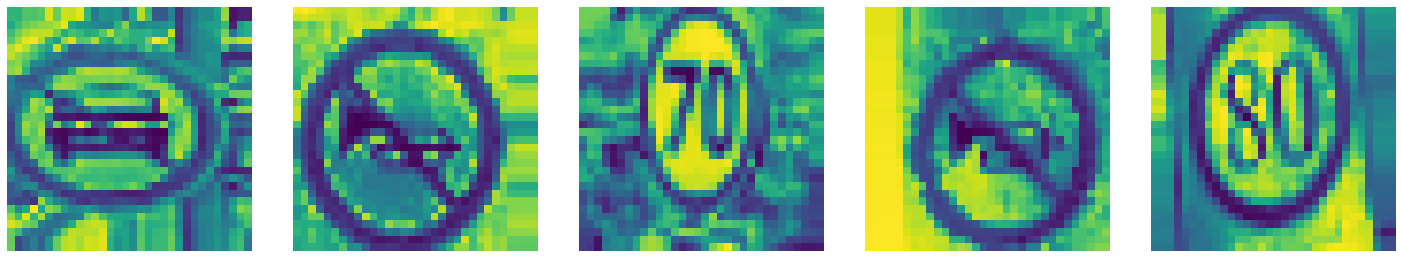

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

In [3]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img
    
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img


x_train = np.array(list(map(preprocessing,x_train)))
x_validation = np.array(list(map(preprocessing,x_validation)))
x_test = np.array(list(map(preprocessing,x_test)))
#cv2.imshow("Grayscale images ", x_train[random.randint(0,len(x_train)-1)])

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_validation=x_validation.reshape(x_validation.shape[0],x_validation.shape[1],x_validation.shape[2],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

dataGen = ImageDataGenerator(width_shift_range=0.1,
                                height_shift_range =0.1,
                                zoom_range=0.2,
                                shear_range=0.1,
                                rotation_range=10)

dataGen.fit(x_train)
batches = dataGen.flow(x_train,y_train,batch_size=6)
x_batch, y_batch = next(batches)

fig,axs = plt.subplots(1,5,figsize=(20,5))
fig.tight_layout()
for i in range(5):
    axs[i].imshow(x_batch[i].reshape(imageDimensions[0],imageDimensions[1]))
    axs[i].axis('off')
plt.show()

y_train =  to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)


def myModel():
    no_Of_Filters = 60
    size_of_Filter = (5,5)
    size_Of_Filter2=(3,3)
    size_of_pool=(2,2)
    no_Of_Nodes = 500
    model= Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimensions[0],imageDimensions[1],1),activation='relu')))
    model.add((Conv2D(no_Of_Filters,size_of_Filter,activation='relu')))
    model.add(MaxPooling2D(pool_size = size_of_pool))

    model.add((Conv2D(no_Of_Filters//2,size_Of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters//2,size_Of_Filter2,activation='relu')))
    model.add(MaxPooling2D(pool_size= size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses,activation='softmax'))
    #model.compile(keras.optimizers.Adam(learning_rate = 0.001),loss='categorical crossentropy',metrics=['accuracy'])
    model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
model = myModel()
print(model.summary())

In [ ]:
history = model.fit(dataGen.flow(x_train,y_train,batch_size = batch_size_val),epochs = epochs_val,validation_data=(x_test,y_test))
#history = model.fit(dataGen.flow(x_train,y_train,batch_size = batch_
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

model.save('detect_bienbao.h5')



In [5]:
from tensorflow.keras.models import load_model
model2= load_model('detect_bienbao.h5')
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array 
from keras.models import load_model
import numpy as np  

shape is:  (32, 32, 3)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
This is:  Toc do toi da cho phep (5km/h)


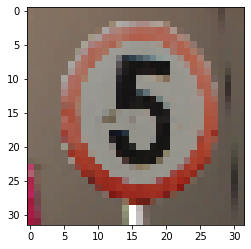

In [6]:
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(32, 32,1))	
	
	return img
labels = {
    0: 'Toc do toi da cho phep (5km/h)',
    1: 'Toc do toi da cho phep (15km/h)',
    2: 'Toc do toi da cho phep (30km/h)',
    3: 'Toc do toi da cho phep (40km/h)',
    4: 'Toc do toi da cho phep (50km/h)',
    5: 'Toc do toi da cho phep (60km/h)',
    6: 'Toc do toi da cho phep (70km/h)',
    7: 'Toc do toi da cho phep (80km/h)',
    8: 'Cam di thang va re trai',
    9: 'Cam di thang va re phai',
    10: 'Cam di thang',
    11: 'Cam re trai',
    12: 'Cam re trai va re phai',
    13: 'Cam re phai',
    14: 'None',
    15: 'Cam quay dau xe',
    16: 'Cam o to',
    17: 'Cam su dung coi',
    18: 'Het han che toc do toi da (40km/h)',
    19: 'Het han che toc do toi da (50km/h)',
    20: 'Cac xe chi duoc di thang va re phai',
    21: 'Huong di thang phai theo',
    22: 'Cac xe chi duoc re trai',
    23: 'Cac xe chi duoc re trai va phai',
    24: 'Cac xe chi duoc re phai',
    25: 'Huong phai di vong sang trai',
    26: 'Huong phai di vong sang phai',
    27: 'Noi giao nhau chay theo vong xuyen'
}
filename = '/content/drive/MyDrive/data_china/0/000_0001.png'
img = load_image(filename)
plt.imshow(img)
img = img_to_array(img)
print('shape is: ',img.shape)
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = img.reshape(1,32,32,1) 
img.shape
result = model.predict(img)
print(result)
np.argmax(result) 
print('This is: ',labels[np.argmax(result)]) 